# Helheim Glacier Project - ATM Airborne Lidara Data Preparation for Surface Fitting 
## Download ATM ICESSN v2 data and convert to GeoDataFrames and GeoDataPackages with fractional year then save windowed output to single HDF5 for surface fitting

**Summary:** this notebook includes code and instructions on how to download ATM ICESSN v2 data from the National Snow and Ice Data Center, convert the individual files into GeoDataFrames and GeoDataPackages, window the merged data with the search polygon and save into a single HDF5 file.   

The NASA Airborne Topographic Mapper (ATM) ICESSNv2 data contains resampled and smoothed elevation measurements from ATM's airborne lidar instruments.  
All data are freely available from the National Snow and Ice Data Center (data set ID: ILATM2).  
Download data: https://nsidc.org/data/ilatm2/versions/2  
DOI: 10.5067/CPRXXK3F39RV

**Note**: fractional years are truncated to the day of the survey without HH:MM:SS information. UTC seconds past midnight are preserved in the converted files GPKG files and can be used to create UTC-based timetags for each platelet.

# STEP 01: download ATM ICESSN v2 data from NSIDC using the NSIDC Data Access Tool

1) open the NSIDC Data Acces Tool for downloading ATM ICESSN v2 data: https://nsidc.org/data/data-access-tool/ILATM2/versions/2
2) click on the polygon icon in the upper right of the map window on the left side
3) upload the search polygon in GeoJSON format: /home/jovyan/shared-public/off_track/Sierra/HelheimGlacier-aoi.geojson **INSERT CORRECT LINK HERE**
4) enter the start and end dates for your search in the "Filter by date" fields above the map: 01/01/2014 to 01/01/2019
5) click the "Download Script" on the lower right to download a Python script with the search parameters and save into the folder you want the data to be downloaded to.
6) Run the Python script to download the data.

In [1]:
import geopandas as gpd
f_name_search = "/home/jovyan/shared-public/off_track/Sierra/HelheimGlacier-aoi.geojson"
df_search = gpd.read_file(f_name_search).to_crs(3413)
# plot search area with OpenStreetMap as basemap
df_search.explore()

# STEP 02: Convert downloaded data CSV files to GeoDataFrames and save as GeoDataPackage files with fractional year

In [2]:
# import necessary modules

import os
import glob
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from   datetime import timezone
import pointCollection as pc
import matplotlib.pyplot as plt

### Loop over all ICESSN v2 files in a given folder and convert them to GPKG files with fractional year added

In [3]:
# loop over all ICESSN v2 files in a given folder and convert them to GPKG files with fractional year added

count = 0 # count processed files

for file in glob.glob("/home/jovyan/shared-public/off_track/Sierra/ATM/ILATM2_*.csv"):

    f_name_gis = file.replace("csv","gpkg") # file name for export
    # read ICESSN v2 ASCII csv files into dataframe 
    icessn_df = pd.read_csv(file, skiprows = 11) # use 11 for version 2
     
    if icessn_df.shape[1] == 11:
        icessn_df.columns = ['sec', 'lat', 'lon', 'ele', 'slope_ns','slope_ew','rms_fit','n_pts_used','n_pts_edited','x_track_m','track_id']
        # drop columns that are not needed for this project
        icessn_df = icessn_df.drop(columns=['slope_ns','slope_ew','rms_fit','n_pts_used','n_pts_edited','x_track_m'])
    
    # need to wrap ATM longitudes to ±180° for exporting geographic coordinates 
    # 0° to 360° is not supported for GeoDataFrames
    icessn_df["lon"] = np.mod(icessn_df["lon"] - 180.0, 360.0) - 180.0
    
    # extract survey date from ICESSN file name
    f_parts_inp = os.path.split(file)
    f_name_date_str = f_parts_inp[1][7:15]
    year  = int(f_name_date_str[0:4])
    month = int(f_name_date_str[4:6])
    day   = int(f_name_date_str[6:8])
    
    # create datetime object of survey date
    survey_date = datetime.datetime(year,month,day).replace(tzinfo=timezone.utc)
    
    # calculate fractional year
    start = datetime.date(survey_date.year, 1, 1).toordinal()
    year_length = datetime.date(survey_date.year+1, 1, 1).toordinal() - start
    year_fractional = survey_date.year + float(survey_date.toordinal() - start) / year_length
    
    # populate lat lon geometry in GeoDataFrame
    atm_gdf = gpd.GeoDataFrame(icessn_df, geometry=gpd.points_from_xy(icessn_df["lon"], icessn_df["lat"]))
    
    # add fractional year to GeoDataFrame
    atm_gdf.insert(atm_gdf.shape[1], "year_fractional", year_fractional)
    
    # remove redundant lon lat columns
    atm_gdf = atm_gdf.drop(columns=["lon","lat"])
    
    # set up the coordinate system
    # EPSG:4326 WGS84 - World Geodetic System 1984, used in DGPS solutions for ATM geolocation
    atm_gdf = atm_gdf.set_crs("EPSG:4326")  #
    
    # export file as GeoDataPackage
    atm_gdf.to_file(f_name_gis, driver="GPKG")
    print(".", end='') # display progress durnig loop
    count = count + 1

print(f'\n\nConverted {count:d} ICESSN files.')

................................................................

Converted 64 ICESSN files.


# STEP 03: Merge individual GeoDataPackages

In [4]:
import glob
D_ATM=[]
count = 0 # count processed files
for file in glob.glob('/home/jovyan/shared-public/off_track/Sierra/ATM/*.gpkg'):
    df=gpd.read_file(file).to_crs(3413)
    Di = pc.data().from_dict({'x':np.array(df.geometry.x),'y':np.array(df.geometry.y),'t':np.array(df.year_fractional),'z':df.ele})
    D_ATM += [Di]
    print(".", end='') # display progress durnig loop
    count = count + 1

print(f'\n\nMerged {count:d} GPKG files.')

D_ATM=pc.data().from_list(D_ATM)
D_ATM.assign(sigma=np.ones_like(D_ATM.x)*0.1)

................................................................

Merged 64 GPKG files.


<class 'pointCollection.data.data'> with shape (132342,),
with fields:
['x', 'y', 't', 'z', 'sigma']

# STEP 04: window merged data to actual search polygon and make QC plot

In [5]:
# need to crop downloaded data to actual search box
df=gpd.read_file(f_name_search).to_crs(3413)
xy=np.array(df.geometry[0].exterior.coords)
D_ATM.crop([[np.min(xy[:,0]), np.max(xy[:,0])], [np.min(xy[:,1]), np.max(xy[:,1])]])
print(f'Found {D_ATM.shape[0]:d} data points inside search polygon.')

Found 88513 data points inside search polygon.


In [6]:
%matplotlib widget

Text(0, 0.5, 'Elevation [m]')

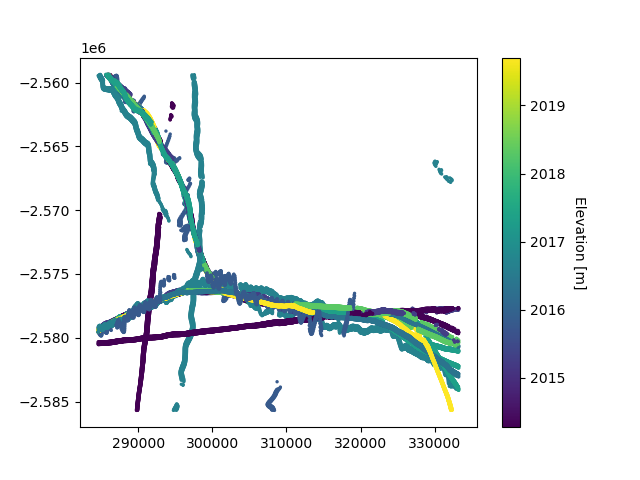

In [7]:
# make quick quality control plot with elevations
plt.figure()
cbar = plt.colorbar(plt.scatter(D_ATM.x, D_ATM.y, 2, c=D_ATM.t))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Elevation [m]', rotation=270)

In [8]:
%matplotlib widget

Text(0, 0.5, 'Elevation [m]')

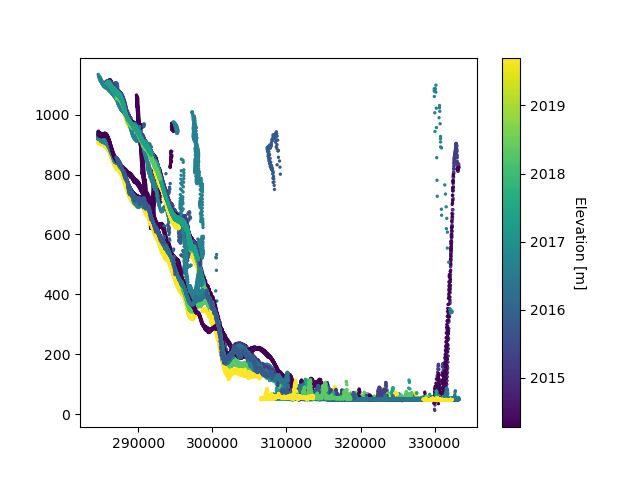

In [9]:
plt.figure()
cbar = plt.colorbar(plt.scatter(D_ATM.x, D_ATM.z, 2, c=D_ATM.t))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Elevation [m]', rotation=270)

In [10]:
%matplotlib widget

Text(0, 0.5, 'Elevation [m]')

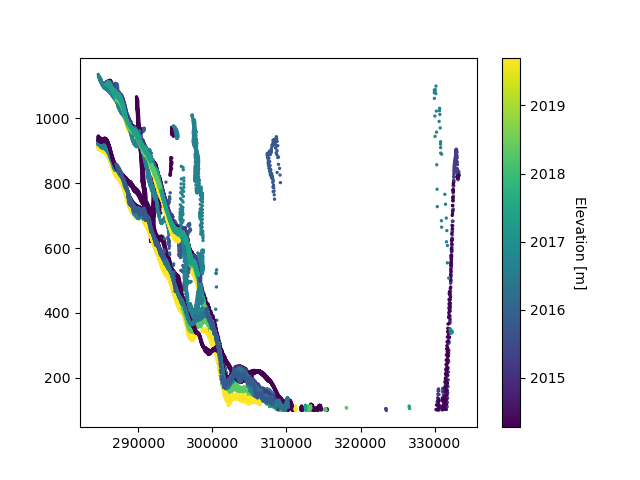

In [11]:
plt.figure()
cbar = plt.colorbar(plt.scatter(D_ATM.x[(D_ATM.z>100)], D_ATM.z[(D_ATM.z>100)], 2, c=D_ATM.t[(D_ATM.z>100)]))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Elevation [m]', rotation=270)

Text(0, 0.5, 'Elevation [m]')

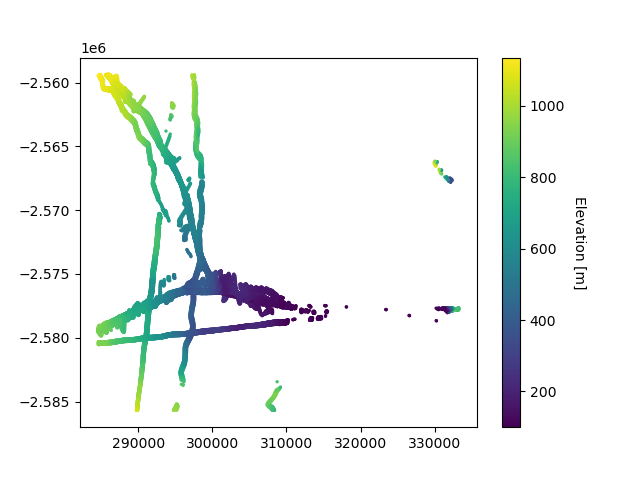

In [12]:
plt.figure()
cbar = plt.colorbar(plt.scatter(D_ATM.x[(D_ATM.z>100)], D_ATM.y[(D_ATM.z>100)], 2, c=D_ATM.z[(D_ATM.z>100)]))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Elevation [m]', rotation=270)

# STEP 05: save merged and windowed data into a single HDF5 file for analysis

In [13]:
D_ATM.to_h5('/home/jovyan/shared-public/off_track/Sierra/ATM/collected_ICESSN.h5')

In [14]:
# show what's in the data
D_ATM

<class 'pointCollection.data.data'> with shape (88513,),
with fields:
['x', 'y', 't', 'z', 'sigma']